In [36]:
# from google.colab import drive
# drive.mount('/content/drive')

In [37]:
# cd /content/drive/MyDrive/data/오토인코더

In [38]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


In [39]:
# pfcn_small.npz에서 train_images, test_images, train_mattes, test_mattes를 np array로 로드하세요.
pfcn_small = np.load('data/pfcn_small.npz')
list(pfcn_small)

['train_images', 'test_images', 'train_mattes', 'test_mattes']

In [40]:
train_images = pfcn_small['train_images']
train_mattes = pfcn_small['train_mattes']
test_images = pfcn_small['test_images']
test_mattes = pfcn_small['test_mattes']

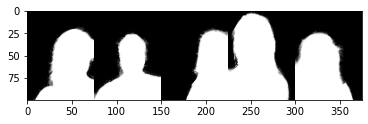

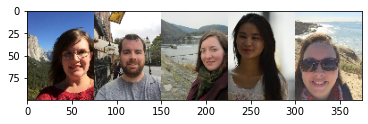

In [41]:
plt.imshow(np.hstack(train_mattes[:5]),cmap='gray')
plt.show()
    
plt.imshow(np.hstack(train_images[:5]))
plt.show()

In [42]:
print(np.shape(train_mattes))
print(np.shape(train_images))

print(np.shape(test_mattes))
print(np.shape(test_images))

(1700, 100, 75)
(1700, 100, 75, 3)
(300, 100, 75)
(300, 100, 75, 3)


In [43]:

print(train_images.max(), train_images.min())
print(test_images.max(), test_images.min())

1.0 0.0
1.0 0.0


In [44]:
# 1(채널)을 추가해 shape을 맞춰주는 함수
train_mattes =np.expand_dims(train_mattes,axis=3)
test_mattes=np.expand_dims(test_mattes,axis=3)
train_mattes.shape, test_mattes.shape

((1700, 100, 75, 1), (300, 100, 75, 1))

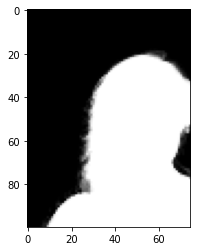

In [45]:
plt.imshow(train_mattes[0].reshape(100,75),cmap='gray')

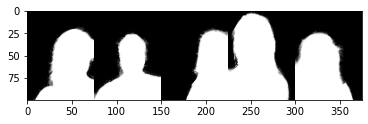

In [46]:
                            # (100,5,75,1) 의 1번자료, 0번자료, 2번자료, 3번자료를 가져와 주세요라는 의미
plt.imshow(train_mattes[:5].transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray")
          # [5채널, 100너비, 75높이, 1채널]
plt.show()

## AE 모델링

In [47]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, UpSampling2D, Flatten, Reshape
from keras.models import Model

def ae_like():
  inputs = Input((100, 75, 3))
  x = Conv2D(32, 3, 2, activation='relu', padding='same')(inputs)
  x = Conv2D(64, 3, 2, activation='relu', padding='same')(x)
  x = Conv2D(128, 3, 2, activation='relu', padding='same')(x)
  x = Flatten()(x)
  latent = Dense(10)(x)

  x = Dense((13 * 10 * 128))(latent)
  x = Reshape((13, 10, 128))(x)

  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(128, (2,2), (1,1), activation='relu', padding='valid')(x)
  
  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(64, (1,1), (1,1), activation='relu', padding='valid')(x)

  x = UpSampling2D(size = (2,2))(x)
  x = Conv2D(32, (1,2), (1,1), activation='relu', padding='valid')(x)

  x = Conv2D(1, (1,1), (1,1), activation='sigmoid')(x)


  model = Model(inputs, x)
  return model

In [48]:
model = ae_like()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 75, 3)]      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 50, 38, 32)        896       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 25, 19, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 10, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 16640)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                166410    
_________________________________________________________________
dense_3 (Dense)              (None, 16640)             1830

In [49]:
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [50]:
hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 2s 28ms/step - loss: 0.1406 - accuracy: 0.7513 - val_loss: 0.1257 - val_accuracy: 0.7625
Epoch 2/25
54/54 [==============================] - 1s 22ms/step - loss: 0.1248 - accuracy: 0.7642 - val_loss: 0.1203 - val_accuracy: 0.7726
Epoch 3/25
54/54 [==============================] - 1s 22ms/step - loss: 0.1153 - accuracy: 0.7751 - val_loss: 0.1021 - val_accuracy: 0.7949
Epoch 4/25
54/54 [==============================] - 1s 22ms/step - loss: 0.0934 - accuracy: 0.8070 - val_loss: 0.0878 - val_accuracy: 0.8117
Epoch 5/25
54/54 [==============================] - 1s 22ms/step - loss: 0.0844 - accuracy: 0.8195 - val_loss: 0.0809 - val_accuracy: 0.8226
Epoch 6/25
54/54 [==============================] - 1s 23ms/step - loss: 0.0766 - accuracy: 0.8300 - val_loss: 0.0767 - val_accuracy: 0.8271
Epoch 7/25
54/54 [==============================] - 1s 23ms/step - loss: 0.0690 - accuracy: 0.8398 - val_loss: 0.0773 - val_accuracy: 0.8253
Epoch 8/25
54

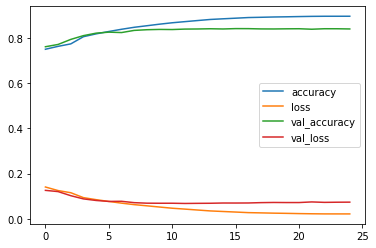

In [51]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend(loc = "center right")
plt.show()

In [52]:

res = model.predict( test_images[0:1] )

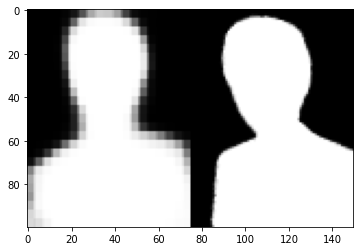

In [53]:
plt.imshow( np.concatenate([res[0], test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray") 
plt.show()

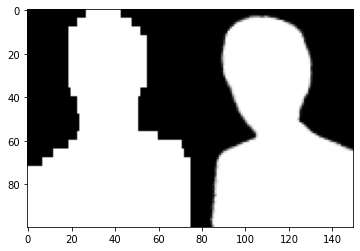

In [54]:
# res를 0.5기준으로 0,1의 값으로 이원화 시켜서 경계영역을 좀더 명확하게 함
plt.imshow( np.concatenate([(res[0] > 0.5).astype(np.float64), test_mattes[0]]).reshape((2, -1, 75, 1)).transpose([1, 0, 2, 3]).reshape((100, -1)), cmap="gray") 
plt.show()

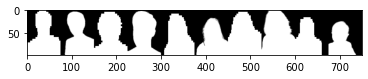

In [55]:

five = (model.predict(test_images[:5]) > 0.5).astype(np.float64)
plt.imshow( np.concatenate([five , test_mattes[:5]], axis=2).transpose((1, 0, 2, 3)).reshape(100, -1) , cmap="gray") 
plt.show()


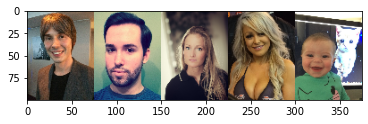

In [56]:
plt.imshow(test_images[:5].transpose((1, 0, 2, 3)).reshape((100, -1, 3))) 
plt.show()

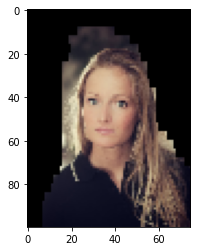

In [57]:
# 예측 이미지와 원본이미지를 곱하여 배경을 지움

plt.imshow ( five[2].reshape((100, 75, 1)) * test_images[2]  )
plt.show()

##  U-net 모델링

In [58]:
# input (100, 75, 3), output (100, 75, 1)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, MaxPool2D, concatenate

def conv2d_block(x, channel):
  x = Conv2D(channel, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(channel, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def unet_like():
  inputs = Input((100, 75, 3))

  c1 = conv2d_block(inputs, 16)
  p1 = MaxPool2D((2,2))(c1)
  p1 = Dropout(0.1)(p1)

  c2 = conv2d_block(p1, 32)
  p2 = MaxPool2D((2,2))(c2)
  p2 = Dropout(0.1)(p2)

  c3 = conv2d_block(p2, 64)
  p3 = MaxPool2D((2,2))(c3)
  p3 = Dropout(0.1)(p3)

  c4 = conv2d_block(p3, 128)
  p4 = MaxPool2D((2,2))(c4)
  p4 = Dropout(0.1)(p4)

  c5 = conv2d_block(p4, 256)

  u6 = Conv2DTranspose(128, 2, 2, output_padding=(0,1))(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(0.1)(u6)
  c6 = conv2d_block(u6, 128)

  u7 = Conv2DTranspose(64, 2, 2, output_padding=(1,0))(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(0.1)(u7)
  c7 = conv2d_block(u7, 64)

  u8 = Conv2DTranspose(32, 2, 2, output_padding=(0,1))(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(0.1)(u8)
  c8 = conv2d_block(u8, 32)

  u9 = Conv2DTranspose(16, 2, 2, output_padding=(0,1))(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(0.1)(u9)
  c9 = conv2d_block(u9, 16)

  outputs = Conv2D(1, (1,1), activation="sigmoid")(c9)

  model = Model(inputs, outputs)
  return model

In [59]:
# unet_like() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = unet_like()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 100, 75, 16)  448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 100, 75, 16)  64          conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 100, 75, 16)  0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [60]:

model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

In [61]:

hist = model.fit(train_images, train_mattes, validation_data=(test_images, test_mattes), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 6s 55ms/step - loss: 0.1099 - accuracy: 0.7826 - val_loss: 0.1546 - val_accuracy: 0.7154
Epoch 2/25
54/54 [==============================] - 2s 46ms/step - loss: 0.0568 - accuracy: 0.8565 - val_loss: 0.2632 - val_accuracy: 0.5957
Epoch 3/25
54/54 [==============================] - 2s 45ms/step - loss: 0.0473 - accuracy: 0.8665 - val_loss: 0.1303 - val_accuracy: 0.7582
Epoch 4/25
54/54 [==============================] - 3s 46ms/step - loss: 0.0406 - accuracy: 0.8730 - val_loss: 0.1576 - val_accuracy: 0.7195
Epoch 5/25
54/54 [==============================] - 3s 46ms/step - loss: 0.0346 - accuracy: 0.8793 - val_loss: 0.1180 - val_accuracy: 0.7642
Epoch 6/25
54/54 [==============================] - 3s 49ms/step - loss: 0.0304 - accuracy: 0.8839 - val_loss: 0.1406 - val_accuracy: 0.7679
Epoch 7/25
54/54 [==============================] - 3s 49ms/step - loss: 0.0294 - accuracy: 0.8846 - val_loss: 0.0458 - val_accuracy: 0.8628
Epoch 8/25
54

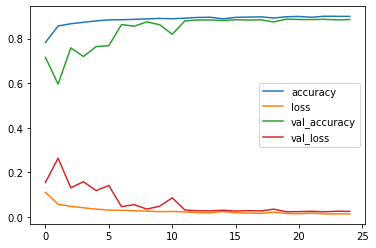

In [62]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label = "accuracy")
plt.plot(hist.history['loss'], label = "loss")
plt.plot(hist.history['val_accuracy'], label = "val_accuracy")
plt.plot(hist.history['val_loss'], label = "val_loss")
plt.legend(loc = "center right")
plt.show()

In [63]:
loss, acc = model.evaluate(test_images, test_mattes, verbose=1)
print(loss, acc)

10/10 [==============================] - 0s 12ms/step - loss: 0.0246 - accuracy: 0.8855
0.02456515096127987 0.8855141997337341


In [64]:

res = model.predict( test_images[2:3] )

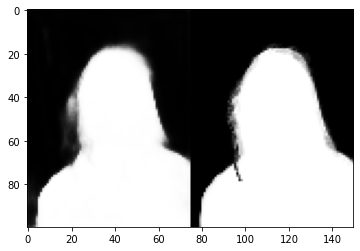

In [65]:
imgs = np.concatenate([res.reshape((100, 75, 1)), test_mattes[2]]).reshape((2, -1, 75, 1)).transpose((1,0, 2, 3)).reshape((100, -1))
plt.imshow(imgs, cmap="gray")
plt.show()

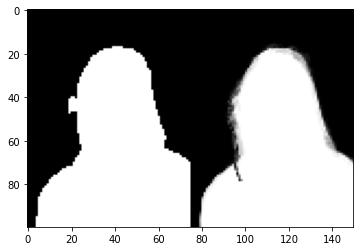

In [66]:

imgs = np.concatenate([(res > 0.5).astype(np.float64).reshape((100, 75, 1)), test_mattes[2] ]).reshape((2, -1, 75, 1)).transpose((1,0, 2, 3)).reshape((100, -1))
plt.imshow(imgs, cmap="gray")
plt.show()


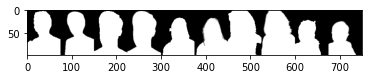

In [67]:

five = (model.predict(test_images[:5]) > 0.5).astype(np.float64)
plt.imshow( np.concatenate([five , test_mattes[:5]], axis=2).transpose((1, 0, 2, 3)).reshape(100, -1) , cmap="gray") 
plt.show()

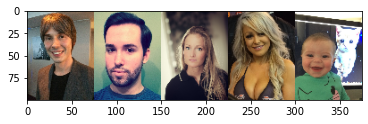

In [68]:
plt.imshow(test_images[:5].transpose((1,0, 2, 3)).reshape((100, -1, 3)))
plt.show()

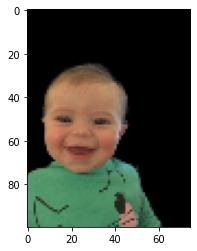

In [69]:
# 아래와 같이 나오는게 목적임(제공되는 배경제거 자료와 매칭한 자료임)
plt.imshow(test_images[4] * test_mattes[4].reshape((100, 75 ,1)))
plt.show()

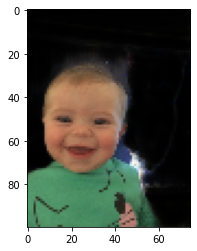

In [70]:
# 딥러닝으로 나온 결과
plt.imshow(test_images[4] * model.predict(test_images[4:5]).reshape((100, 75 ,1)))
plt.show()

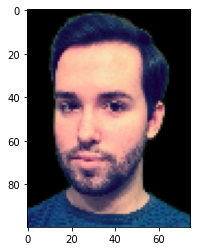

In [74]:
# 아래와 같이 나오는게 목적임(제공되는 배경제거 자료와 매칭한 자료임)
plt.imshow(test_images[1] * test_mattes[1].reshape((100, 75 ,1)))
plt.show()

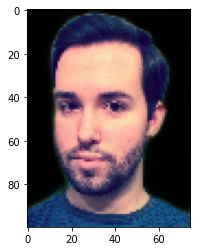

In [75]:
# 딥러닝으로 나온 결과
plt.imshow(test_images[1] * model.predict(test_images[1:2]).reshape((100, 75 ,1)))
plt.show()

In [71]:
# 모델을 저장하는 코드를 작성하세요.
model.save("./배경제거.h5")